## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [75]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
# get feature statistics
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


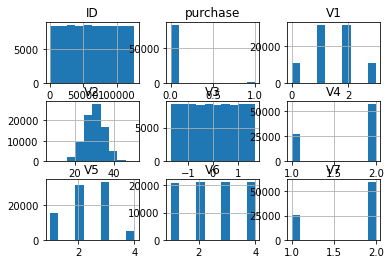

In [4]:
# check feature distributions
train_data.hist();

It looks like most of the features have been encoded in some way.

In [5]:
# how many users get the promotion and avail it
train_data[train_data.Promotion=="Yes"]['purchase'].value_counts()/len(train_data[train_data.Promotion=="Yes"])

0    0.982981
1    0.017019
Name: purchase, dtype: float64

This data is highly imbalanced since people availing the offer are less than 2%.

In [6]:
# get users that received the promotion
promotion_df = train_data[train_data.Promotion=="Yes"]

In [7]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sb.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sb.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sb.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

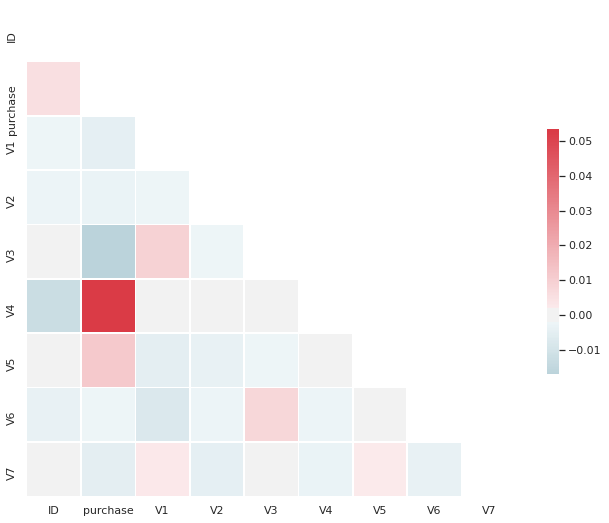

In [9]:
multi_collinearity_heatmap(promotion_df)

Features <b>V4</b> and <b>V5</b> have a postive correlation with the 'purchase' whereas feature <b>V3</b> seems to have a negative correlation.

# Statistical Analysis

In [10]:
# check the invariant metric

n_obs = train_data.shape[0]
n_control = train_data[train_data.Promotion=="No"].shape[0]
n_exp = train_data[train_data.Promotion=="Yes"].shape[0]
print("Total users: ", n_obs)
print("Control group users:", n_control)
print("Experiment group users:", n_exp)

Total users:  84534
Control group users: 42170
Experiment group users: 42364


In [11]:
# calculate z score and p value
p = 0.5 # random split results in 50:50 split
mean = n_obs * p
std = np.sqrt(p * (1-p) * n_obs)
z = ((n_control + 0.5) - mean) / std
print("z-score:",z)
print("p-value:", 2 * sp.stats.norm.cdf(z))

z-score: -0.6638066506192843
p-value: 0.5068140685419046


From the p value, we can say that the metric is not statistically significant, thus we can move on to the evaluation metrics.

A p-value is a measure of the probability that an observed difference could have occurred just by random chance. The lower the p-value, the greater the statistical significance of the observed difference.

In [12]:
# check the evaluation metric

p_purchase = train_data.groupby('Promotion').mean()['purchase']
n_control = train_data.groupby('Promotion').size()[0]
n_exper = train_data.groupby('Promotion').size()[1]
p_null = train_data['purchase'].mean()

# compute standard error, z-score, and p-value
se_p = np.sqrt(p_null * (1-p_null) * (1/n_control + 1/n_exper))

z = (p_purchase[1] - p_purchase[0]) / se_p
print(z)
print(1-sp.stats.norm.cdf(z))

12.468449461599388
0.0


Since the p-value is 0, the evaluation metric is statistically significant.

# Metrics to Optimize

In [87]:
# Incremental response rate
# IRR depicts how many more customers purchased the product with the promotion,
# as compared to if they didn't receive the promotion. 

def compute_irr(df):
    
    purch_control = df.loc[df.Promotion=="No", 'purchase'].sum()
    purch_exp = df.loc[df.Promotion=="Yes", 'purchase'].sum()
    
    n_control = df.groupby('Promotion').size()[0]
    n_exp = df.groupby('Promotion').size()[1]
    
    irr = (purch_exp/n_exp) - (purch_control/n_control)
    return irr

# Net Incremental Revenue (NIR)
# how much is made or lost by sending out the promotion

def compute_nir(df):
    
    purch_control = df.loc[df.Promotion=="No", 'purchase'].sum()
    purch_exp = df.loc[df.Promotion=="Yes", 'purchase'].sum()
    n_exp = df.groupby('Promotion').size()[1]
    
    nir = (10 * purch_exp - 0.15 * n_exp) - (10 * purch_control)
    return nir
    

In [88]:
irr = compute_irr(train_data)
print("The incremental response rate is: {} %".format(irr*100))

The incremental response rate is: 0.9454547819772702 %


In [89]:
nir = compute_nir(train_data)
print("The net incremental revenue is: {} $".format(nir))

The net incremental revenue is: -2334.5999999999995 $


According to these results, sending out promotions has cost Starbucks. 
Our goal is now to identify people to whom these promotions should be sent to maximise profits.

# Permutation test: A non-parametric approach

In [100]:
from tqdm import tqdm

def quantile_permtest(df, alternative='less', n_trials = 1000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        df: data in the form of a dataframe 
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform
    
    Output value:
        p: estimated p-value of test
    """
    
    
    # initialize storage of bootstrapped sample quantiles
    sample_irr, sample_nir = [], []
    
    # observed statistic / test statistic
    obs_irr = compute_irr(df)
    obs_nir = compute_nir(df)
    
    # For each trial...
    for _ in tqdm(range(n_trials)):
        # randomly permute the grouping labels
        df.Promotion = np.random.permutation(df.Promotion)
        
        # compute metrics
        sample_irr.append(compute_irr(df))
        sample_nir.append(compute_nir(df))
    
    # compute a p-value
    if alternative == 'less':
        hits_irr = (sample_irr<=obs_irr).sum()
        hits_nir = (sample_nir<=obs_nir).sum()
    elif alternative == 'greater':
        hits_irr = (sample_irr>=obs_irr).sum()
        hits_nir = (sample_nir>=obs_nir).sum()
    
    return (hits_irr / n_trials), (hits_nir / n_trials)


In [101]:
quantile_permtest(train_data, 'greater', 100_000)

100%|██████████| 100000/100000 [39:03<00:00, 42.67it/s]


(0.85262, 0.85262)

According to the tested metrics, the p-values suggest that the promotions offered by Starbucks did not have a significant difference on the purchases made by the user.

# Data Modelling

In [47]:
test_data = pd.read_csv('Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [48]:
test_data.Promotion.value_counts()

No     20902
Yes    20748
Name: Promotion, dtype: int64

In [49]:
# get train and test sets
train_data.Promotion = pd.get_dummies(train_data.Promotion)['Yes']
test_data.Promotion = pd.get_dummies(test_data.Promotion)['Yes']
X_train = train_data.drop(['ID', 'Promotion', 'purchase'], axis=1)
y_train = train_data['purchase']
X_test = test_data.drop(['ID', 'Promotion', 'purchase'], axis=1)
y_test = test_data['purchase']

In [69]:
y_train.value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

In [70]:
import xgboost as xgb

model = xgb.XGBClassifier(scale_pos_weight=80)
model.fit(X_train, y_train)

XGBClassifier(scale_pos_weight=80)

In [71]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     41170
           1       0.02      0.60      0.03       480

    accuracy                           0.59     41650
   macro avg       0.50      0.60      0.39     41650
weighted avg       0.98      0.59      0.74     41650



In [72]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = model.predict(df)
    promotion = np.where(promotion==0, 'No', 'Yes')
    print(promotion)
    return promotion

In [73]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

['No' 'No' 'Yes' ... 'No' 'No' 'No']
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0192.

Your nir with this strategy is 337.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01915373185889607, 337.60000000000014)

Our optimization approach betters the Udacity approach as we get a better net revenue and the incremental response rate also increases by a small amount. 